### Visualize Effect of Uncertainty in a Decline Curve



Given a range of decline paramters [Qi, De, b_factor], visualize changing Decline curve of a well.



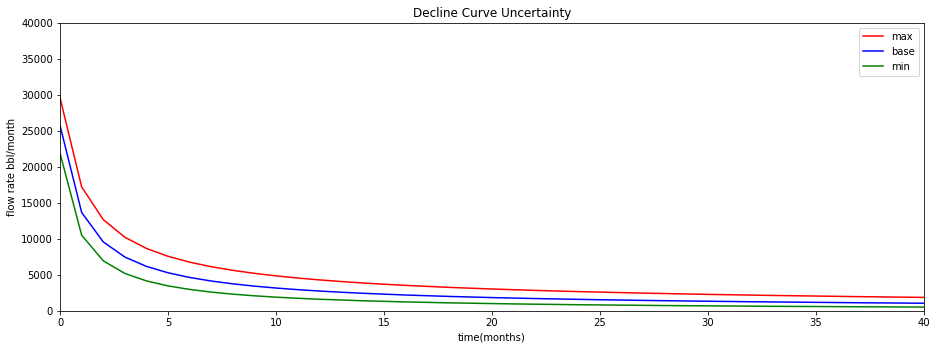

In [2]:
import numpy as np
import statistics as s
import math as m
import matplotlib.pyplot as plt


t = np.arange(0,360) #30 years in terms of months
units = 'bbl'

Qi_day = 845.56
Qi = Qi_day*30.4 #bbl/month
Qmin = .85*Qi
Qmax = 1.15*Qi
Qi_range = np.linspace(Qmin,Qmax,len(t))

De = .9472
Demax = 0.85*De #lower decline is max
Demin = 1.15*De #higher decline is min
De_range = np.linspace(Demin,Demax, len(t))

b = 1.2
bmin = .85*b
bmax = 1.15*b
b_range = np.linspace(bmin,bmax, len(t))

ratesmin = []
rates = []
ratesmax = []
for i in range(0,len(t)):
    ymin = Qmin/(1 + bmin*Demin*t[i])**(1/bmin) 
    y = Qi/(1 + b*De*t[i])**(1/b) 
    ymax = Qmax/(1 + bmax*Demax*t[i])**(1/bmax) 
    
    rates = np.append(rates,y)
    ratesmin = np.append(ratesmin,ymin)
    ratesmax = np.append(ratesmax,ymax)
    
plt.subplot(1,1,1)
plt.plot(t,ratesmax,'red',label = 'max')
plt.plot(t,rates,'blue', label = 'base')
plt.plot(t,ratesmin,'green',label = 'min')
plt.xlabel('time(months)')
plt.ylabel('flow rate '+ units +'/month')
plt.title('Decline Curve Uncertainty')
plt.legend()
plt.xlim(0,40)
plt.ylim(0,40000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)


### Compare Analytical and Numerical solution for cumulative production.



In [3]:

t = np.arange(0,375,.5) #the smaller the time discritization, the more accurate our estimate of the integral is
units = 'bbl'
Qi_day = 845.56
Qi = Qi_day*30.4 #bbl/month
Qmin = .25*Qi
Qmax = 1.25*Qi
Qi_range = np.linspace(Qmin,Qmax,len(t))

De = .9472
Demax = 0.25*De #lower decline is max
Demin = 1.25*De #higher decline is min
De_range = np.linspace(Demin,Demax, len(t))



b = 1.2
bmin = .25*b
bmax = 1.25*b
b_range = np.linspace(bmin,bmax, len(t))

y = Qi/(1 + b*De*t[-1])**(1/b) #where t[-1] is the final time step(grand total)
Cummulative_ProductionEQ = ((Qi**b)/((De)*(1-b)))*((1/(Qi**(b-1)))-((1/(y**(b-1)))))
print('Cummulative Production: Analytical',Cummulative_ProductionEQ)

#Alternatively we can perform trapezoid rule to calculate cummulative production(integrate the decline curve)
#this should return the same result as the analytical solution but with more error based on time discritizations

q = []
for i in range (0,len(t)):
    y = Qi/(1 + b*De*t[i])**(1/b)
    q = np.append(q,y)
    
Cummulative_Production = np.array([0])

for j in range (1,len(t)):
    Np = (q[j-1]+q[j])*(t[j]-t[j-1])/2
    Cummulative_Production = np.append(Cummulative_Production,Cummulative_Production[j-1]+Np)
    
    
print('Cummulative Production: Numerical',Cummulative_Production[-1])

Cummulative Production: Analytical 236612.41214530187
Cummulative Production: Numerical 237107.0482281575


### Measuring Uncertainty in the Estimated Ultimate Recovery of Single well.



Given a range of decline paramters [Qi, De, b_factor], calculate Cummulative Production for a given amount of time.
Use bootstrap (Monte Carlo Simulation) to measure uncertainty in the mean of Cummulative Production.


10% chance of having 254334.37171687794 or more  bbl 
50% chance of having 240747.0151587776 or more  bbl 
90% chance of having 227236.4308186149 or more  bbl 


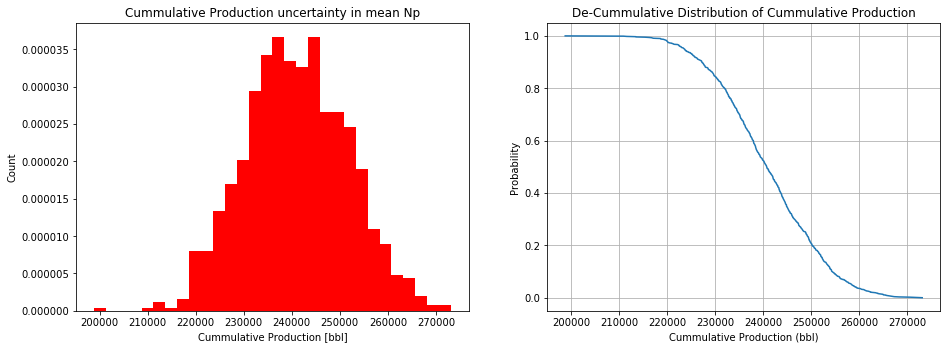

In [5]:



#Bootstrap

n = 0
production = []
while n < 1000:
    n+=1
    Np = []
    samples = []
    for i in range(0,len(t)):
        index = np.random.randint(0,len(t))
        Qt = Qi_range[index]/(1 + b_range[index]*De_range[index]*t[index])**(1/b_range[index])
        Np = np.append(Np,((Qi_range[index]**b_range[index])/((De_range[index])*(1-b_range[index])))*(
            (1/(Qi_range[index]**(b_range[index]-1)))-(1/(Qt**(b_range[index]-1)))))
        
        #once the full distribution for caluculated Np is generated, we calculate the desired statistic on that distribution. That is 1 data point, 
        #repeat the entire sampling process(executed in the for loop), and generate a new full distribution and compute the statistic as data point 2, 
        #repeat n times, so that you build a distribution of n data points (calculated statistics), increase n for better results
    avg = np.mean(Np)
    production = np.append(production, avg)


plt.subplot(1,2,1)
bins = 30
n, bins,patches = plt.hist(production,bins,facecolor = 'r',density=True)
plt.xlabel('Cummulative Production [bbl]')
plt.ylabel('Count')
plt.title('Cummulative Production uncertainty in mean Np')


prob = np.linspace(0,1.0,len(production))
production_cdf = np.sort(production)
production_cdf = np.flip(production_cdf,0)

plt.subplot(1,2,2)

plt.plot(production_cdf,prob)
plt.ylabel('Probability' )
plt.xlabel('Cummulative Production '+ '('+ units +')' )
plt.title('De-Cummulative Distribution of Cummulative Production')
#plt.xlim(0,1.0)
plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

p10 = np.percentile(production_cdf,10)
p50 = np.percentile(production_cdf,50)
p90 = np.percentile(production_cdf,90)

print('10% chance of having',p90,'or more','', units, '')
print('50% chance of having',p50,'or more','', units, '')
print('90% chance of having',p10,'or more','', units, '')



### Using Bootstrap (Monte Carlo Simulation) to Calculate Uncertainty in the Mean Statistic of Estimated Ultimate Recovery

Similarly, if we have a collection of EUR values for a number of wells, say we want to measure uncertainy in the 19th percentile of EUR values for these wells.


10% chance of having a P19 of 621.2121212121212 or higher
50% chance of having a P19 of 595.0 or higher
90% chance of having a P19 of 570.7070707070707 or higher


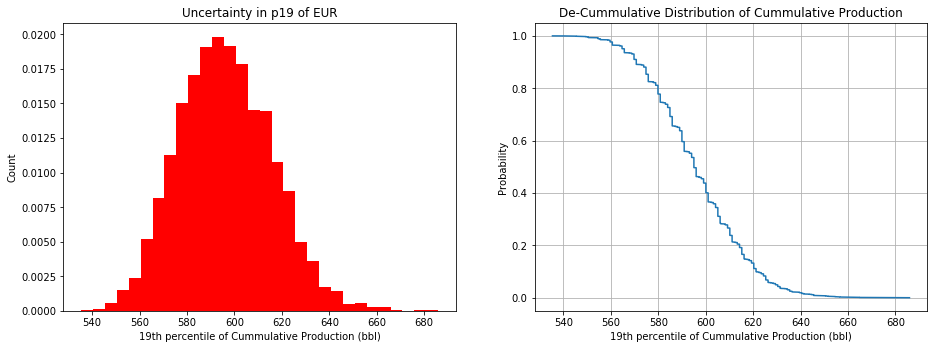

In [12]:
#populate EUR with the estimated Recovery values in any units
#note, EUR can be any data, and the measured statistic (mean in this case) can be any other statistic

EUR = np.linspace(500,1000,100) 
units = 'bbl'
#Bootstrap
n = 0
p19 = []
while n < 5000:
    n+=1
    samples = []
    for i in range(0,len(EUR)):
        index = np.random.randint(0,len(EUR)) #random sampling is key
        samples = np.append(samples,EUR[index])
    percentile19 = np.percentile(samples,19)
    p19 = np.append(p19,percentile19)
    
    
bins = 30
plt.subplot(1,2,1)
n, bins,patches = plt.hist(p19,bins,facecolor = 'r',density=True)
plt.xlabel('19th percentile of Cummulative Production '+ '('+ units +')' )
plt.ylabel('Count')
plt.title('Uncertainty in p19 of EUR')



prob = np.linspace(0,1.0,len(p19))
p19_cdf = np.sort(p19)
p19_cdf = np.flip(p19_cdf,0)


plt.subplot(1,2,2)
plt.plot(p19_cdf,prob)
plt.ylabel('Probability' )
plt.xlabel('19th percentile of Cummulative Production '+ '('+ units +')' )
plt.title('De-Cummulative Distribution of Cummulative Production')
plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

p10 = np.percentile(p19_cdf,10)
p50 = np.percentile(p19_cdf,50)
p90 = np.percentile(p19_cdf,90)

print('10% chance of having a P19 of',p90,'or higher')
print('50% chance of having a P19 of',p50,'or higher')
print('90% chance of having a P19 of',p10,'or higher')
